# We use the GH statuses to find the time on which Circle was adopted

In [46]:
from pymongo import MongoClient

mongo_client = MongoClient()
database = mongo_client["graduation"]
pull_requests_collection = database["pull_requests"]
projects_collection = database["projects"]
commits_collection = database["commits"]

In [47]:
from urllib.parse import urlparse

import datetime

scraped_projects = list(projects_collection.find({'succeeded': True, 
                                                  'travis_is_oldest_ci': {'$exists':False}, 
                                                  'circle_is_oldest_ci': {'$exists': False}, 
                                                  'scrape_type':'icse_1'}))
print("Analyzing {}".format(len(scraped_projects)))

for project in scraped_projects:
    print("-----------------------------------------")
    print("Starting {}".format(project["full_name"]))
    
    pull_requests = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],
                                                       'project_owner': project["full_name"].split("/")[0]},
                                                      {'commits':1, 'raw_comments':1, 'created_at': 1}))
    
    print("got pull-requests")
    
    sha_list = list([commit for pr in pull_requests for commit in pr["commits"]])
        
    commits = [commits_collection.find_one({'sha': sha_hash}, {'statuses': 1}) for sha_hash in sha_list]
    
    print("got commits")
    
    statuses = list([status for commit in commits for status in commit["statuses"]])
    
    print("{} commits, and {} statuses".format(len(commits), len(statuses)))
    
    if len(statuses) == 0:
        # this is pointless, update and continue
        project["status_circle_date"] = None
        project["circle_is_oldest_ci"] = False
        
        projects_collection.replace_one({"_id" : project["_id"]}, project)
        
        continue
    
    print("Oldest reported status is: {}".format(min([status["created_at"] for status in statuses])))
    
    all_urls = [status["target_url"] for status in statuses]
    
    hostnames = list(set([urlparse(url).hostname for url in all_urls if urlparse(url).hostname is not None]))
    
    print("Total of {} unique hostnames".format(len(hostnames)))
    
    print("Hostnames are: {}".format(", ".join(hostnames)))
    
    circle_statuses = list([status["created_at"] for status in statuses if urlparse(status["target_url"]).hostname == "circleci.com"])
    
    if len(circle_statuses) == 0:
        # this is pointless, update and continue
        project["status_circle_date"] = None
        project["circle_is_oldest_ci"] = False
        
        projects_collection.replace_one({"_id" : project["_id"]}, project)
        
        continue
    
    oldest_circle_date = min(circle_statuses)
    
    oldest_status_date = min([status["created_at"] for status in statuses])
    
    print("Oldest circle status is: {}. While oldest status date is {}".format(oldest_circle_date, oldest_status_date))
    
    # We not only need the oldest status date for Travis, we also need the date of
    # the first occurence of the TravisBot in all its glory
    
    travis_bot_pr_dates = list([pr["created_at"] for pr in pull_requests if any([cmmnt for cmmnt in pr["raw_comments"] if cmmnt["user"]["login"] == 'travisbot'])])
    
    if len(travis_bot_pr_dates) == 0:
        travisbot_oldest_date = None
    else:
        travisbot_oldest_date = min(travis_bot_pr_dates)
        
    print("I found an old comment from the travis bot from {}".format(travisbot_oldest_date))
        
    if (travisbot_oldest_date is None or travisbot_oldest_date > oldest_circle_date) and \
    (oldest_circle_date - oldest_status_date).days < 15:
        project["status_circle_date"] = oldest_circle_date
        project["circle_is_oldest_ci"] = True
    else:
        project["status_circle_date"] = oldest_circle_date
        project["circle_is_oldest_ci"] = False
    
        
  
    
    projects_collection.replace_one({"_id" : project["_id"]}, project)
    

Analyzing 0


# How many PRs do the circle projects have

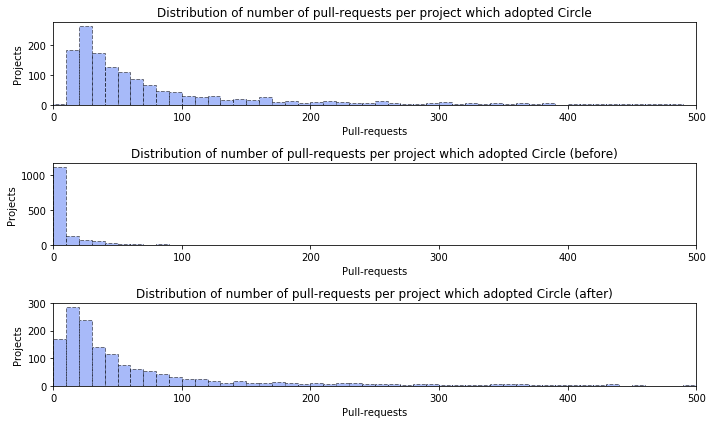

Total of 304 projects with at least 12 before and 12 after


In [42]:
import analysis_utilities
import matplotlib.pyplot as plt

circle_projects = list(projects_collection.find({'succeeded': True, 
                                                  'circle_is_oldest_ci': True, 
                                                  'scrape_type':'icse_1'}))
nr_prs = []
nr_prs_before = []
nr_prs_after = []

available_projects = 0

for project in circle_projects:
    
    project_slug_split = project["full_name"].split("/")
    
    project_name = project_slug_split[1]
    project_owner = project_slug_split[0]
    
    nr_prs.append(pull_requests_collection.count_documents({'project_name': project_name, 'project_owner': project_owner}))
    
    prs_list = list(pull_requests_collection.find({'project_name': project_name, 'project_owner': project_owner}, {'created_at': 1}))
    
    (prs_before, prs_after) = analysis_utilities.split_prs_on_build_date(project, prs_list, field_name="status_circle_date")
    
    nr_prs_before.append(len(prs_before))
    nr_prs_after.append(len(prs_after))
    
    if len(prs_before) >= 12 and len(prs_after) >= 12:
        available_projects += 1

    
fig = plt.figure(figsize=(10,6))

ax = plt.subplot(3, 1, 1)

plt.hist(nr_prs, bins = 50, color='#5177f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 2)

plt.hist(nr_prs_before, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle (before)")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

ax = plt.subplot(3, 1, 3)

plt.hist(nr_prs_after, bins = 50, color='#5277f5', alpha=0.5, range=(0,500), ls='dashed', edgecolor='black')

plt.xlim(0, 500)

ax.set_title("Distribution of number of pull-requests per project which adopted Circle (after)")

plt.xlabel("Pull-requests")
plt.ylabel("Projects")

plt.tight_layout()

plt.show()

print("Total of {} projects with at least 12 before and 12 after".format(available_projects))

# Fill up time buckets to count RDD projects

In [43]:
import statistics
import math

def calculate_share_review_comments(prs, project):
    total_review_comments = sum([len(pr["review_comments"]) for pr in prs])
    total_general_comments = sum([len(pr["raw_comments"]) for pr in prs])

    total = total_review_comments + total_general_comments   

    if total == 0:
        share_review_comments = 0
    else: 
        share_review_comments = total_review_comments / total
        
    return share_review_comments

def project_name(prs, project):
    return project["full_name"]

def sum_field(fieldname, is_list = False):
    def sum_field_func(prs, project):
        if is_list:
            return sum([math.log(len(pr[fieldname]) + 1) for pr in prs]) /len(prs)
        else:
            return sum([math.log(pr[fieldname] + 1) for pr in prs]) / len(prs)
        
    return sum_field_func

def total_prs(prs, project):
    return len(prs)

def commits_after_create_count(prs, project):
    
    vals = []
    
    for pr in prs:
    
        total = 0
        
        for sha in pr["commits"]:
            commit = commits_collection.find_one({'sha': sha}, {'date': 1})
            
            if commit is not None and 'date' in commit and commit["date"] > pr["created_at"]:
                total += 1
                
        vals.append(total)
        
    return statistics.mean([math.log(x + 1) for x in vals])

def num_of_unique_users_count(prs, project):
    
    vals = []
    
    for pr in prs:
        num_of_unique_users = len(set([cmmnt["user"]["login"] for cmmnt in pr["review_comments"] if cmmnt["user"] is not None] + [cmmnt["user"]["login"] for cmmnt in pr["raw_comments"] if cmmnt["user"] is not None]))
        vals.append(num_of_unique_users)
        
    return statistics.mean([math.log(x + 1) for x in vals])

def project_language(prs, project):
    return project["language"]

def sum_effective_comments(prs, project):
    total = 0    
    for pr in prs:    
        total += math.log(len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) + 1)
        
    return total/len(prs)
    
metrics_to_calculate = [
    {'Name': 'ProjectName', 'Func': project_name},
    {'Name': 'Language', 'Func': project_language},
    {'Name': 'ShareReviewComments', 'Func': calculate_share_review_comments},
    {'Name': 'Additions', 'Func': sum_field("additions")},
    {'Name': 'Deletions', 'Func': sum_field("deletions")},
    {'Name': 'ChangedFiles', 'Func': sum_field("changed_files")},
    {'Name': 'Assignees', 'Func': sum_field("assignees", True) },
    {'Name': 'ReviewComments', 'Func': sum_field("review_comments", True)},
    {'Name': 'GeneralComments', 'Func': sum_field("raw_comments", True)},
    {'Name': 'TotalPrs', 'Func': total_prs},
    {'Name': 'Commits', 'Func': sum_field("commits", True)},
    {'Name': 'CommitsAfterCreate', 'Func': commits_after_create_count},
    {'Name': 'EffectiveComments', 'Func': sum_effective_comments},
    {'Name': 'NumOfUniqueUsers', 'Func': num_of_unique_users_count}
]

In [45]:
from datetime import datetime, timedelta
   
period = 30
periods = 24

metric_collection = {}

for metric in metrics_to_calculate:
    metric_collection[metric["Name"]] = [[] for x in range(periods + 1)]

circle_projects = list(projects_collection.find({'succeeded': True, 
                                                  'circle_is_oldest_ci': True, 
                                                  'scrape_type':'icse_1',
                                                  'status_circle_date': {'$exists': True}}))
skipped = 0

for project in circle_projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]},
                                            {'bigrams': 0, 'body': 0, 'review_comments.bigrams': 0, 'review_comments.body': 0, 'raw_comments.bigrams': 0,
                                                    'raw_comments.body': 0}))

    travis_date = project["status_circle_date"]
    
    if travis_date is None:
        continue

    start_date = travis_date - timedelta(days=period/2 + period*(periods/2))

    empty_period = 0

    split_prs = []

    for i in range(periods + 1):
        end_date = start_date + timedelta(days=period)

        prs_in_period = []

        for pr in prs:
            if pr["created_at"] > start_date and pr["created_at"] < end_date:
                prs_in_period.append(pr)

        if len(prs_in_period) == 0:
            empty_period += 1
        

        split_prs.append(prs_in_period)

        start_date = end_date

    if empty_period > 0:
        skipped += 1
        continue

    for i in range(len(split_prs)):
        prs_in_period = split_prs[i]
        
        # We append None to indicate that this period has no data-points
        for metric in metrics_to_calculate:
            if len(prs_in_period) == 0:
                metric_collection[metric["Name"]][i].append(None)
            else:
                metric_collection[metric["Name"]][i].append(metric["Func"](prs_in_period, project))

print("Total of {} scraped projects".format(projects_collection.find({'scrape_type': 'icse_1', 'succeeded':True}).count()))
print("Skipped {} out of {}".format(skipped, len(circle_projects)))

        

Total of 2844 scraped projects
Skipped 1577 out of 1589


/home/nathancassee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
